In [1]:
# Packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import time

## Load Data(.mat) files:

In [2]:
train_images = scipy.io.loadmat('/Users/gardasnagarjun/Downloads/datasets/multi-class/train_images.mat')
train_label=scipy.io.loadmat('/Users/gardasnagarjun/Downloads/datasets/multi-class/train_labels.mat')


test_images=scipy.io.loadmat('/Users/gardasnagarjun/Downloads/datasets/multi-class/test_images.mat')
test_labels=scipy.io.loadmat('/Users/gardasnagarjun/Downloads/datasets/multi-class/test_labels.mat')

In [3]:
# Keep the format of the training samples in 'float32', and the labels in 'long' types.
train_X,train_Y,test_X,test_Y=train_images['train_images'].astype('float32'),train_label['train_labels'].astype('long'),test_images['test_images'].astype('float32'),test_labels['test_labels'].astype('long')

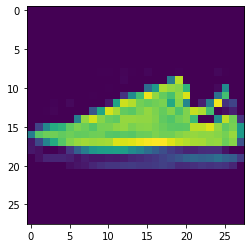

In [23]:
#Visualise one instance of the data:
img=train_X[6].reshape(28,28)
plt.imshow(img)

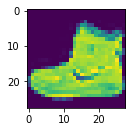

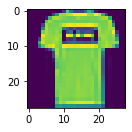

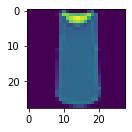

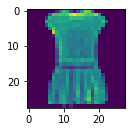

In [24]:
# Let's check the variety of the images given in the data:
for i in range(4):
    plt.subplot(2,3,i+1)
    img=train_X[i].reshape(28,28)
    plt.imshow(img)  
    plt.show()

In [5]:
# Split the training dataset into train,validation datasets for checking the model accuracy:
X_train,val_X,train_y,val_Y=train_test_split(train_X,train_Y[0],test_size=0.2)

print(len(train_X))
print(len(X_train))
print(len(val_X))

10000
8000
2000


In [6]:
print(train_X.shape,X_train.shape,val_X.shape,train_y.shape,val_Y.shape)
print(len(train_X))

(10000, 784) (8000, 784) (2000, 784) (8000,) (2000,)
10000


In [7]:
#Construct two datasets for torch.util.data.dataloader:

"""Dataloaders are used to keep the data in batches."""
#Inputs: training dataset
#Outputs: Train, valid dataloaders

main_data=[]
for i in range(len(train_X)):
    train_X.astype('float32')
    train_Y.astype('long')
    main_data.append([train_X[i],train_Y[0][i]])
    
mainloader=torch.utils.data.DataLoader(main_data,shuffle=True,batch_size=20)
i4,l4=next(iter(mainloader)) #checking the tensor shape
print(i4.shape)


train_data = []
for i in range(len(X_train)):
    X_train.astype('float32')
    train_y.astype('long')
    train_data.append([X_train[i], train_y[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=25)
i1, l1 = next(iter(trainloader))
print(i1.shape)

val_data=[]
for i in range(len(val_X)):
    val_X.astype('float32')
    val_Y.astype('long')
    val_data.append([val_X[i], val_Y[i]])

valloader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=25)
i2, l2 = next(iter(valloader))
print(i2.shape)


test_data=[]
for i in range(len(test_X)):
    test_X.astype('float32')
    test_Y.astype('long')
    test_data.append([test_X[i],test_Y[0][i]])
    
testloader=torch.utils.data.DataLoader(test_data,shuffle=False)

i3,l3=next(iter(testloader))
print(i3.shape)

torch.Size([20, 784])
torch.Size([25, 784])
torch.Size([25, 784])
torch.Size([1, 784])


In [8]:
print(len(mainloader))
print(len(trainloader))
print(len(valloader))
print(len(testloader))
#Check how the tensors are stored in the loader class given in pytorch:
for i,j in enumerate(valloader):
    print(i,j)
    break

500
320
80
1000
0 [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([4, 0, 6, 8, 2, 1, 0, 1, 3, 1, 3, 6, 2, 8, 4, 7, 3, 6, 9, 6, 5, 1, 3, 0,
        7])]


In [9]:
'''Neural Network Model'''

#Define the model of your Neural Network:
# two hidden layers with input as features of the data and the labels as output

#input=784 (28*28)
#hidden1,hidden2= Number of hidden nodes
#Output=10 classes

#Activation used: ReLu function
class two_hidden(nn.Module):
    def __init__(self,n_hidden1,n_hidden2,n_output=10,n_feature=784):
        super(two_hidden,self).__init__()
        self.hidden_1=nn.Linear(n_feature,n_hidden1)
        self.hidden_2=nn.Linear(n_hidden1,n_hidden2)
        self.output=nn.Linear(n_hidden2,n_output)
        
    def forward(self,x):
        x1=F.relu(self.hidden_1(x))
        x2=F.relu(self.hidden_2(x1))
        x=self.output(x2)
        
        return x

In [10]:
#To check whether the model is defined or not:
net_trial=two_hidden(75,20)
print(net_trial)

two_hidden(
  (hidden_1): Linear(in_features=784, out_features=75, bias=True)
  (hidden_2): Linear(in_features=75, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=10, bias=True)
)


### Define necessary functions for the training of the model:

In [11]:
 #Calculate Accuracy:      
def accuracy(net,valloader):
    net.eval()
    with torch.no_grad():
        n_correct=0
        n_samples=0
        for data,target in valloader:
            output=net(data)
            _,predicted=torch.max(output.data,1)
            n_samples+=target.size(0)
            n_correct+=(predicted==target).sum().item()
            
        acc=100.0* n_correct/n_samples
        print(f'Accuracy of the network for val data: {acc} %')
        return acc
    

In [12]:
def accuracy_test(net,testloader):
    with torch.no_grad():
        net.eval()
        n_correct = 0
        n_samples = 0
        for z, y in testloader:
            outputs = net(z)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += y.size(0)
            n_correct += (predicted == y).sum().item()
            
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network for test data: {acc} %')

### Train the model through average loss per epoch:

In [13]:
#This training loop is of without steps like done above 
#here the loss is calculated on an average with every 'epoch':

def model_train(net,trainloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    # number of epochs to train the model
    n_epochs = 30  # suggest training between 20-50 epochs
    loss_values=[] #To store the losses for plotting

    for epoch in range(n_epochs):
    # monitor training loss
        train_loss = 0.0
    
    ###################
    # train the model #
    ###################
        for data, target in trainloader:
        # clear the gradients of all optimized variables
            optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
            output = net(data)
        # calculate the loss
            loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
        # perform a single optimization step (parameter update)
            optimizer.step()
        # update running training loss
            train_loss += loss.item()*data.size(0)
            
        
    # print training statistics 
    # calculate average loss over an epoch
        train_loss = train_loss/len(trainloader.dataset)
        loss_values.append(train_loss)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))
    plt.plot(loss_values) # Plot the loss curve
    
    # accuracy of the validation dataset with the model trained.
    acc=accuracy(net,valloader)
    return acc

Epoch: 1 	Training Loss: 1.820100
Epoch: 2 	Training Loss: 1.590424
Epoch: 3 	Training Loss: 1.738031
Epoch: 4 	Training Loss: 1.292201
Epoch: 5 	Training Loss: 1.115619
Epoch: 6 	Training Loss: 0.933465
Epoch: 7 	Training Loss: 0.832697
Epoch: 8 	Training Loss: 0.805244
Epoch: 9 	Training Loss: 0.760519
Epoch: 10 	Training Loss: 0.727263
Epoch: 11 	Training Loss: 0.699986
Epoch: 12 	Training Loss: 0.678959
Epoch: 13 	Training Loss: 0.627269
Epoch: 14 	Training Loss: 0.592510
Epoch: 15 	Training Loss: 0.592443
Epoch: 16 	Training Loss: 0.576619
Epoch: 17 	Training Loss: 0.547808
Epoch: 18 	Training Loss: 0.546283
Epoch: 19 	Training Loss: 0.527507
Epoch: 20 	Training Loss: 0.522156
Epoch: 21 	Training Loss: 0.520904
Epoch: 22 	Training Loss: 0.497246
Epoch: 23 	Training Loss: 0.494355
Epoch: 24 	Training Loss: 0.495965
Epoch: 25 	Training Loss: 0.488013
Epoch: 26 	Training Loss: 0.483404
Epoch: 27 	Training Loss: 0.463173
Epoch: 28 	Training Loss: 0.454483
Epoch: 29 	Training Loss: 0.4

Epoch: 19 	Training Loss: 0.415433
Epoch: 20 	Training Loss: 0.401566
Epoch: 21 	Training Loss: 0.409460
Epoch: 22 	Training Loss: 0.391723
Epoch: 23 	Training Loss: 0.372034
Epoch: 24 	Training Loss: 0.360294
Epoch: 25 	Training Loss: 0.343823
Epoch: 26 	Training Loss: 0.326983
Epoch: 27 	Training Loss: 0.337895
Epoch: 28 	Training Loss: 0.319623
Epoch: 29 	Training Loss: 0.308866
Epoch: 30 	Training Loss: 0.308683
Accuracy of the network for val data: 84.2 %
Epoch: 1 	Training Loss: 2.005175
Epoch: 2 	Training Loss: 1.597856
Epoch: 3 	Training Loss: 1.397672
Epoch: 4 	Training Loss: 0.919724
Epoch: 5 	Training Loss: 0.734429
Epoch: 6 	Training Loss: 0.664949
Epoch: 7 	Training Loss: 0.601161
Epoch: 8 	Training Loss: 0.544760
Epoch: 9 	Training Loss: 0.525907
Epoch: 10 	Training Loss: 0.492427
Epoch: 11 	Training Loss: 0.503161
Epoch: 12 	Training Loss: 0.436870
Epoch: 13 	Training Loss: 0.410194
Epoch: 14 	Training Loss: 0.420505
Epoch: 15 	Training Loss: 0.371571
Epoch: 16 	Training

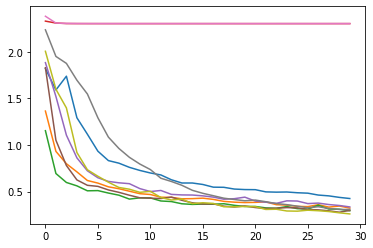

In [14]:
'''Finding Hidden layer nodes'''
#Using a for loop to iterate over the possible values for the best hidden nodes for the two layers, training the model
# And finding the accuracy of the validation dataset and comparing to find the best one.
h1=[50,75,100]
h2=[10,15,20]
storage=dict()
for i in h1:
    for x in h2:
        net=two_hidden(i,x)
        storage[i,x]=model_train(net,trainloader)
        
print(storage)

Epoch: 1 	Training Loss: 1.053178
Epoch: 2 	Training Loss: 0.613114
Epoch: 3 	Training Loss: 0.534949
Epoch: 4 	Training Loss: 0.489534
Epoch: 5 	Training Loss: 0.465006
Epoch: 6 	Training Loss: 0.445856
Epoch: 7 	Training Loss: 0.429387
Epoch: 8 	Training Loss: 0.413619
Epoch: 9 	Training Loss: 0.406527
Epoch: 10 	Training Loss: 0.397263
Epoch: 11 	Training Loss: 0.396496
Epoch: 12 	Training Loss: 0.365020
Epoch: 13 	Training Loss: 0.377121
Epoch: 14 	Training Loss: 0.365986
Epoch: 15 	Training Loss: 0.354156
Epoch: 16 	Training Loss: 0.343052
Epoch: 17 	Training Loss: 0.331825
Epoch: 18 	Training Loss: 0.341072
Epoch: 19 	Training Loss: 0.324921
Epoch: 20 	Training Loss: 0.359505
Epoch: 21 	Training Loss: 0.319594
Epoch: 22 	Training Loss: 0.304734
Epoch: 23 	Training Loss: 0.307471
Epoch: 24 	Training Loss: 0.303863
Epoch: 25 	Training Loss: 0.304984
Epoch: 26 	Training Loss: 0.293030
Epoch: 27 	Training Loss: 0.307396
Epoch: 28 	Training Loss: 0.303897
Epoch: 29 	Training Loss: 0.2

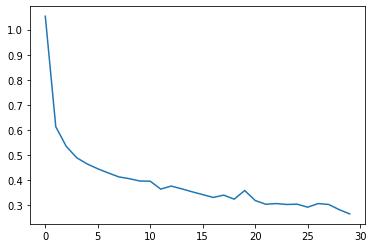

In [15]:
#defining the model with best hidden parameters
start_time_best=time.time()
model_best=two_hidden(75,20)
#train the model and get the val accuracy:
model_train(model_best,mainloader)
end_time_best=time.time()
# Training time for the model to train
print(f"Training time: {end_time_best-start_time_best}s")

In [16]:
#Test dataset accuracy
accuracy_test(model_best,testloader)

Accuracy of the network for test data: 84.2 %


In [17]:
#Confusion matrix and accuracy of per class:
no_classes = 10

confusion_matrix = torch.zeros(no_classes, no_classes)
with torch.no_grad():
    for i, (x, classes) in enumerate(testloader):
        outputs = model_best(x)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 93.,   1.,   3.,   4.,   0.,   0.,   5.,   0.,   1.,   0.],
        [  0., 100.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,   0.,  82.,   1.,  12.,   0.,  12.,   0.,   0.,   0.],
        [  6.,   2.,   4.,  75.,   2.,   0.,   4.,   0.,   0.,   0.],
        [  0.,   0.,  12.,   3.,  93.,   0.,   7.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  79.,   0.,   1.,   0.,   7.],
        [ 21.,   0.,  12.,   4.,   9.,   0.,  51.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   2.,   0.,  92.,   0.,   1.],
        [  1.,   0.,   0.,   1.,   0.,   0.,   1.,   5.,  87.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   4.,   0.,  90.]])


In [18]:
#Accuracy per class taken from the confusion matrix:

print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.8692, 0.9524, 0.7387, 0.8065, 0.8087, 0.9080, 0.5258, 0.9684, 0.9158,
        0.9474])


### Training the model with steps:
 To get a better understaning of how the step parameter is utilised, can run the following to get a best hidden parameters, and find the best accuracy:

In [ ]:
# Train the model
def train_with_steps(net,trainloader):
    
    #parameters:
    #lr=learning rate
    #Loss function-CrossEntropyLoss
    #Optimizers tried: Adam,SGD
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    #torch.manual_seed(0)
    n_total_steps = len(trainloader)
    num_epochs=30
    
    for epoch in range(num_epochs):
        for i,(data,target) in enumerate(trainloader):
            #optimizer.zero_grad()
            
            # Forward pass    
            output = net(data)
            loss = criterion(output, target)
        
        
            # Backward and optimize
            optimizer.zero_grad()
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
             # perform a single optimization step (parameter update)
            optimizer.step()
            
            
            if (i+1) % 32 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}],Step:[{i+1}/{n_total_steps}] Loss: {loss.item():.5f}')
                
    acc=accuracy(net,valloader)
    return acc

In [ ]:
h1=[50,75,100]
h2=[10,15,20]
storage=dict()
for i in h1:
    for x in h2:
        net=two_hidden(i,x)
        storage[i,x]=train_with_steps(net,trainloader)
        
print(storage)

In [ ]:
net_best=two_hidden()
train_with_steps(net_best,trainloader)
accuracy_test(net_best,testloader)